# Border

Optimized compactness extraction - faster code

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

#Boarder extraction feature using classical compactness formula, but optimized courner detection techniques
def B_compactness(m):
    """Perfect circle -> 1
       Irregular shape -> close to zero"""
    #converting image to gray scale (remove before working with classifier) -> should be binary
    mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    #function used to find all detected borders, shapes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #extracting the largest boarder, furthest from the center with largest area
    largest_contour = max(contours, key=cv2.contourArea)
    #computes euclidean distancesfor perimeter determination, close = True for closed countour shape
    perimeter = cv2.arcLength(largest_contour, closed=True)
    #calculates area using Green’s Theorem treating contour as a polygon
    area = cv2.contourArea(largest_contour)
    #calculating compactness using classical formula
    compactness = (4 * np.pi * area) / (perimeter ** 2)#scale invariant

    return compactness


In [ ]:
import cv2
import numpy as np

def radial_ring_gap_area(path):

    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return np.nan

    # Largest contour
    contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(contour)

    if M['m00'] == 0:
        return np.nan

    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Compute distances from centroid to contour points
    distances = [np.sqrt((pt[0][0] - cx) ** 2 + (pt[0][1] - cy) ** 2) for pt in contour]
    radius = int(np.mean(distances))  # could also use max(distances)

    # Create fitted circle mask
    circle_mask = np.zeros_like(binary, dtype=np.uint8)
    cv2.circle(circle_mask, (cx, cy), radius, 255, thickness=-1)

    # XOR to find difference
    difference = cv2.bitwise_xor(circle_mask, binary)
    ring_gap_area = np.sum(difference > 0)

    # Optionally normalize by lesion area
    lesion_area = np.sum(binary > 0)
    relative_gap = ring_gap_area / lesion_area

    return round(relative_gap, 4)

gap_score = radial_ring_gap_area('./sinthetic/star.png')
print("Ring gap irregularity score:", gap_score)


Ring gap irregularity score: 0.578


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def count_inflection_points(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0

    # Use the largest contour
    contour = max(contours, key=cv2.contourArea)
    pts = contour[:, 0, :]  # shape (N, 2)

    # Make the contour circular (closed loop)
    pts = np.concatenate([pts[-2:], pts, pts[:2]])

    # First derivatives (tangent vectors)
    d1 = pts[2:-1] - pts[1:-2]  # shape (N, 2)
    d2 = pts[3:] - 2 * pts[2:-1] + pts[1:-2]  # Second derivative approximation

    # Cross product of d1 and d2 gives signed curvature direction
    cross = d1[:, 0] * d2[:, 1] - d1[:, 1] * d2[:, 0]  # shape (N,)

    # Detect zero-crossings in curvature sign
    signs = np.sign(cross)
    sign_changes = np.diff(signs)
    inflections = np.sum(sign_changes != 0)

    return inflections




num_inflections = count_inflection_points("./sinthetic/star.png")
print("Number of border inflection points:", num_inflections)


Number of border inflection points: 1346


Testing with synthetic data if compactness gives perdictable values

In [239]:
print(f'star: {B_compactness('./sinthetic/star.png')}')
print(f'circle: {B_compactness('./sinthetic/circle.jpg')}')

star: 0.06372674272145322
circle: 0.7853981633974484


Perfect circle → Compactness = 1 (this is the maximum possible value).

Less compact / uneven shapes → Compactness approaches 0.

In [ ]:
import cv2
import numpy as np

def roughness(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = contours[0]

    M = cv2.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])


    distances = [np.sqrt((pt[0][0] - cx)**2 + (pt[0][1] - cy)**2) for pt in contour]

 
    mean_dist = np.mean(distances)
    std_dev = np.std(distances)
    mad = np.mean(np.abs(distances - mean_dist))
    border_roughness = std_dev / mean_dist


    return border_roughness


In [242]:
print(f'star: {roughness('./sinthetic/star.png')}')
print(f'circle: {roughness('./sinthetic/circle.jpg')}')

star: 0.2712254261967975
circle: 0.001712024670574707


The code that we were provided by last year students - slow running time

In [ ]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from skimage import morphology

def get_compactness(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    

    mask = mask > 0 

    area = np.sum(mask)
    if area == 0:
        return 0

    struct_el = morphology.disk(3)

    try:
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        perimeter = np.sum(mask & ~mask_eroded)
    except Exception as e:
        print(f"Error processing {mask_path}: {e}")
        return 0

    if perimeter == 0:
        return 0

    return round((4 * np.pi * area) / (perimeter ** 2), 4)

In [246]:
print(f'star: {get_compactness('./sinthetic/star.png')}')
print(f'circle: {get_compactness('./sinthetic/circle.jpg')}')

star: 0.0075
circle: 0.0376


Iterating through some images and extracting compactness

In [ ]:

data = pd.read_csv('feature_extraction_set.csv')

mask_dir = './data/lesion_masks/'

data['compactness'] = np.nan

for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = radial_ring_gap_area(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

Trial of standardization

In [274]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['compactness_std'] = scaler.fit_transform(data[['compactness']])

Checking data frame compactness

In [280]:
data

,diagnostic,img_id,img_base,compactness
0,1,PAT_106_159_325.png,PAT_106_159_325,0.2333
1,0,PAT_107_160_609.png,PAT_107_160_609,0.1289
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.0817
3,0,PAT_26_37_865.png,PAT_26_37_865,0.1496
4,1,PAT_98_152_562.png,PAT_98_152_562,0.3561
...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.1559
116,1,PAT_135_202_593.png,PAT_135_202_593,0.1743
117,1,PAT_90_138_605.png,PAT_90_138_605,0.1741
118,1,PAT_160_249_76.png,PAT_160_249_76,0.1437


Class distribution check

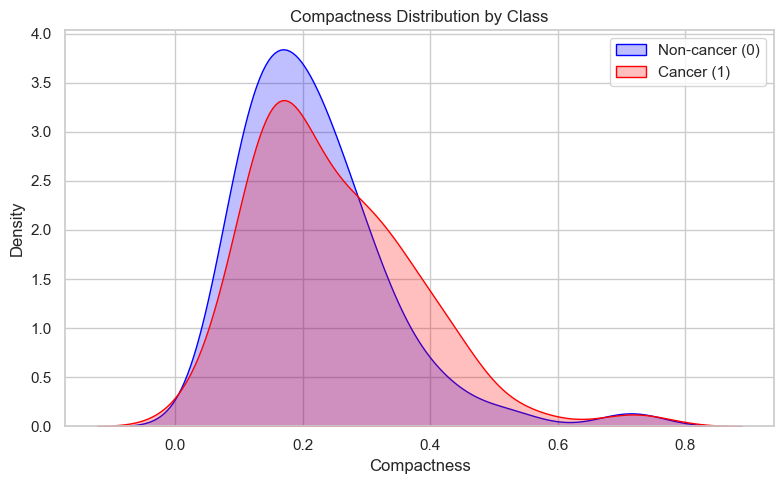

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='compactness', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='compactness', label='Cancer (1)', fill=True, color='red')

plt.title('Compactness Distribution by Class')
plt.xlabel('Compactness')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()



# Asymetry

In [ ]:
import cv2
import numpy as np
from math import floor, ceil
from skimage.transform import rotate

#Main call -> mean_asymmetry

"""Calculating asymetry score by rotating image 4 times(90 degrees) and calculating
asymetry each time"""

def cut_mask(mask):
    """Removing big part of black background to avoid misleading 
    asymetry and computational cost"""
    rows = np.any(mask, axis=1) #rows that have white pixels
    cols = np.any(mask, axis=0) #columns that have white pixels

    row_min, row_max = np.where(rows)[0][[0, -1]] #indexes of white rows
    col_min, col_max = np.where(cols)[0][[0, -1]] #indexes of white columns

    return mask[row_min:row_max+1, col_min:col_max+1] #bounding box of the lesion

def find_midpoint(image):
    """Mid point detection of the lesion, where image is grayscale mask"""
    return image.shape[0] // 2, image.shape[1] // 2 #middle row, middle column (x,y)

def asymmetry(mask):
    """Measuring shape asymetry of the mask"""
    row_mid, col_mid = find_midpoint(mask) #middle point

    #splitting the mask into 4 halves
    upper = mask[:row_mid, :]
    lower = mask[-row_mid:, :]
    left = mask[:, :col_mid]
    right = mask[:, -col_mid:]

    #flipping bottom and right half
    flipped_lower = np.flipud(lower) #flip up
    flipped_right = np.fliplr(right) #flip left

    #the following codes are used to ensure that when halves are compared,
    #the arrays have the same sizes for np.logical_xor() to work
    hmin = min(upper.shape[0], flipped_lower.shape[0]) #picks the smallest number of rows
    vmin = min(left.shape[1], flipped_right.shape[1]) #picks the smallest number of columns

    #counting mismatched pixels
    hori_xor = np.logical_xor(upper[:hmin, :], flipped_lower[:hmin, :])
    vert_xor = np.logical_xor(left[:, :vmin], flipped_right[:, :vmin])

    #calculating the area -> sum of the white pixels
    total = np.sum(mask)
    if total == 0: #if mask is black to avoid division by zero error
        return np.nan

    #calculating the asymetry score (0 perfect symetry, 1 very asymetric)
    score = (np.sum(hori_xor) + np.sum(vert_xor)) / (2 * total) 
    #total mismatch standardized by total pixels in lesion tp get score 0 to 1
    return round(score, 4)

def rotation_asymmetry(mask, n=4):
    """Rotating the picture n times and getting asymetry 
    scores for every rotation"""
    asymmetry_scores = []

    for i in range(n):
        deg = 360 * i / n
    #optimization, if the angle is multiple of 90 use np.rot90 which is faster than rotate function
        if deg % 90 == 0:
            k = int(deg // 90)
            rotated = np.rot90(mask, k)
        else:
            rotated = rotate(mask, deg, preserve_range=True, order=0).astype(np.uint8)

        cropped = cut_mask(rotated > 0)#creating a binary bounded lesion, avoiding interpolation artifacts
        score = asymmetry(cropped)
        asymmetry_scores.append(score)

    return asymmetry_scores

def mean_asymmetry(path, rotations=4):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if mask is None: #check if mask exists
        return np.nan
    mask = (mask > 0).astype(np.uint8) #binarizing because mask is in gray scale

    scores = rotation_asymmetry(mask, rotations)
    return round(np.nanmean(scores), 4)



In [250]:
print(f'Asymetric figure: {mean_asymmetry('./data/lesion_masks/PAT_9_17_80_mask.png')}')
print(f'Symetric figure:{mean_asymmetry('./sinthetic/circle.jpg')}')

Asymetric figure: 0.6029
Symetric figure:0.0037


A perfectly symmetric shape gives a score near 0.

An irregular or asymmetric shape gives a score approaching 1.

Iteration through some images

In [ ]:

mask_dir = './data/lesion_masks/'

data['asymmetry'] = np.nan

for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = mean_asymmetry(mask_path)
            data.at[idx, 'asymmetry'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [261]:
data

,diagnostic,img_id,img_base,compactness,asymmetry
0,1,PAT_106_159_325.png,PAT_106_159_325,0.694909,0.1232
1,0,PAT_107_160_609.png,PAT_107_160_609,0.827416,0.1024
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.890640,0.0380
3,0,PAT_26_37_865.png,PAT_26_37_865,0.825954,0.0887
4,1,PAT_98_152_562.png,PAT_98_152_562,0.795918,0.0646
...,...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.776006,0.0900
116,1,PAT_135_202_593.png,PAT_135_202_593,0.700059,0.1231
117,1,PAT_90_138_605.png,PAT_90_138_605,0.781715,0.0981
118,1,PAT_160_249_76.png,PAT_160_249_76,0.838848,0.1156


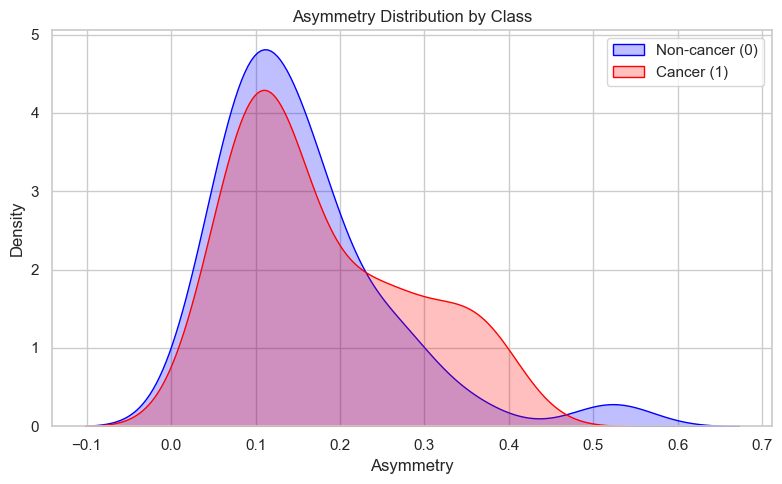

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='asymmetry', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='asymmetry', label='Cancer (1)', fill=True, color='red')

plt.title('Asymmetry Distribution by Class')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Hair feature

Hair coverage feature extraction code

In [213]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hair_coverage(image_path, visual = False):
    img_org = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    #reduces image noise, skin texture, and small bumps before edge detection
    blurred = cv2.GaussianBlur(img_org, (7,7), 0) 

    #laplacian operator highlights areas of rapid intensity change -> edge detection
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=3) #cv2.CV_64F sets the data type to 64-bit float so it can hold both positive and negative values
    laplacian_abs = np.absolute(laplacian) #remove negative edges, because we don't care about direction (going from light to dark or vice versa), we care about magnitute
    laplacian_norm = cv2.normalize(laplacian_abs, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) #scaling edges to 0–255 for thresholding

    threshold_value = 0.3 * 255
    hair_mask = (laplacian_norm > threshold_value).astype(np.uint8)

    #calculating hair coverage
    hair_pixels = np.sum(hair_mask)
    total_pixels = hair_mask.size
    coverage = hair_pixels / total_pixels

    if visual:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_org, cmap='gray')
        plt.title('Gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(laplacian_norm, cmap='gray')
        plt.title('Laplacian (Normalized)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(hair_mask * 255, cmap='gray')
        plt.title(f'Hair Mask (Coverage = {coverage:.2%})')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return round(coverage, 4)

image_path = './data/skin_images/train_hair/img_2006.png'
hair_coverage(image_path, False)

0.0799

Iterating through mandatory assignment images to get the hair coverage and compare with labels for evaluation

In [219]:
import cv2
import os
import pandas as pd
import numpy as np

image_dir = './data/skin_images/train_hair/'
data2 = pd.read_csv('hair_annotations.csv')
#create one label for an image (0,1,2), take the most frequent rating accross annotators
data2['gt_label'] = data2[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']].mode(axis=1)[0]
#correction
data2['File_ID'] = data2['File_ID'].str.replace('.png', '', regex=False)
#data['gt_label'] = data['gt_label'].replace(0, 1)

data2['coverage'] = None

for idx, row in data2.iterrows():
    img_id = row['File_ID']
    image_path = os.path.join(image_dir, img_id + '.png')

    if os.path.exists(image_path):
        coverage = hair_coverage(image_path, False)
        data2.at[idx, 'coverage'] = coverage
    else:
        print(f"Image not found: {image_path}")

data2.head(15)

,File_ID,Group_ID,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,gt_label,coverage
0,img_1572,M,2,2,2,2,2,2,0.1063
1,img_1573,M,2,2,2,2,2,2,0.0433
2,img_1574,M,0,0,0,0,0,0,0.0027
3,img_1575,M,2,2,2,2,2,2,0.0804
4,img_1576,M,2,2,2,2,2,2,0.0845
5,img_1577,M,0,0,0,0,0,0,0.0025
6,img_1578,M,1,0,1,1,1,1,0.0065
7,img_1579,M,0,0,1,0,0,0,0.0746
8,img_1580,M,1,1,1,1,1,1,0.0178
9,img_1581,M,2,2,2,2,2,2,0.0816


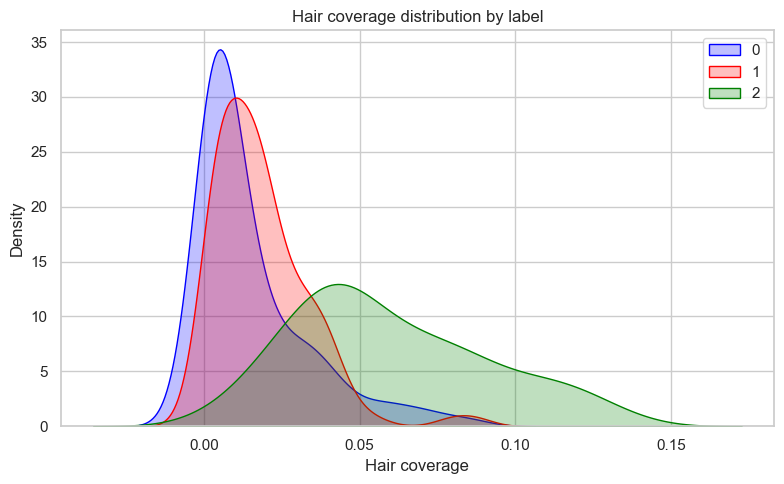

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data2[data2['gt_label'] == 0], x='coverage', label='0', fill=True, color='blue')
sns.kdeplot(data=data2[data2['gt_label'] == 1], x='coverage', label='1', fill=True, color='red')
sns.kdeplot(data=data2[data2['gt_label'] == 2], x='coverage', label='2', fill=True, color='green')


plt.title('Hair coverage distribution by label')
plt.xlabel('Hair coverage')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()